<a href="https://colab.research.google.com/github/130ndim/dul_2021/blob/hw12/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --branch hw12 https://github.com/130ndim/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 598 (delta 229), reused 186 (delta 113), pack-reused 194
Receiving objects: 100% (598/598), 63.65 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27647 sha256=f45aec94dc18fcb56affbfa9ea468f1a81a2e51d9b25d7be45aba1d598604fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ij95fe7/wheels/55/59/29/0fb1c63565

In [2]:
from dul_2021.utils.hw12_utils import *

from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data

from torchvision import transforms as T
from typing import TypeVar

import numpy as np

from tqdm.auto import tqdm


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TorchModel = TypeVar("TorchModel", bound=nn.Module)

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [57]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.seq1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 4, 1),
        )

        self.conv_to_fc = 8 * 8 * 4
        self.seq2 = nn.Sequential(
            nn.BatchNorm1d(self.conv_to_fc),
            nn.Linear(self.conv_to_fc, hid_dim_full),
            nn.ReLU(),
            nn.Linear(hid_dim_full, out_dim),
        )

    def forward(self, x):
        x = self.seq1(x)

        x = x.reshape(-1, self.conv_to_fc)
        
        x = self.seq2(x)

        return x.log_softmax(-1)

In [70]:
class Model(nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def compute_loss_on_batch(self, x, y):
        raise NotImplementedError

    def predict_on_batch(self, x):
        raise NotImplementedError

    def on_after_backward(self):
        pass

    def fit(self, train_dl, test_dl, n_epochs=15, lr=5e-4):
        optimizer = optim.Adam(self.parameters(), lr=lr)

        losses, accuracies = [], []
        metric_dict = {}

        with tqdm(total=(len(train_dl) + len(test_dl)) * n_epochs) as pbar:
            for _ in range(n_epochs):
                pbar.set_description_str('Training')
                self.train()
                for batch in train_dl:
                    x, y = batch
                    x, y = x.to(self.device), y.to(self.device)

                    loss = self.compute_loss_on_batch(x, y)
                    if loss is None:
                        pbar.update()
                        continue
                    loss.backward()
                    self.on_after_backward()

                    optimizer.step()
                    optimizer.zero_grad()

                    metric_dict['loss'] = loss.item()
                    losses.append(metric_dict['loss'])

                    pbar.update()
                    pbar.set_postfix(metric_dict)

                pbar.set_description_str('Testing')
                correct, total = 0, 0
                self.eval()
                with torch.no_grad():
                    for batch in test_dl:
                        x, y = batch
                        x, y = x.to(self.device), y.to(self.device)

                        pred = self.predict_on_batch(x).argmax(-1)

                        correct += (pred == y).sum().item()
                        total += x.size(0)

                        pbar.update()

                    metric_dict['acc'] = correct / total
                    accuracies.append(metric_dict['acc'])
                    pbar.set_postfix(metric_dict)

        return np.array(losses), np.array(accuracies)


class VATReg(nn.Module):
    def __init__(self, xi, eps=1.0):
        super().__init__()
        self._xi = xi
        self._eps = eps

    def forward(self, model: TorchModel, x: torch.Tensor):
        with torch.no_grad():
            p1 = model(x).exp()

        d = torch.randn_like(x)
        d /= d.view(d.size(0), -1).norm(dim=-1)[:, None, None, None]

        model.eval()

        d.requires_grad_()
        log_p2 = model(x + self._xi * d)
        dist = F.kl_div(log_p2, p1, reduction='batchmean')
        dist.backward()

        g = d.grad
        g /= g.view(g.size(0), -1).norm(dim=-1)[:, None, None, None]

        model.zero_grad()

        log_p3 = model(x + g * self._eps)
        model.train()
        return F.kl_div(log_p3, p1, reduction='batchmean')


class VAT(Model):
    def __init__(self, out_dim=10, hidden_dim=128, xi=10.0, eps=1.0):
        super().__init__()
        self.net = Net(out_dim, hidden_dim)

        self.reg = VATReg(xi, eps)

    def predict_on_batch(self, x):
        return self.net(x)

    def compute_loss_on_batch(self, x, y):
        mask = y > -1
        loss = F.nll_loss(self.net(x[mask]), y[mask]) + self.reg(self.net, x)
        return loss


In [5]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    train_dl = data.DataLoader(train_data, batch_size=256, drop_last=True, shuffle=True)
    test_dl = data.DataLoader(test_data, batch_size=256)

    vat = VAT().to(DEVICE)

    losses, accuracies = vat.fit(train_dl, test_dl, n_epochs=5)

    return losses, accuracies


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1175 [00:00<?, ?it/s]

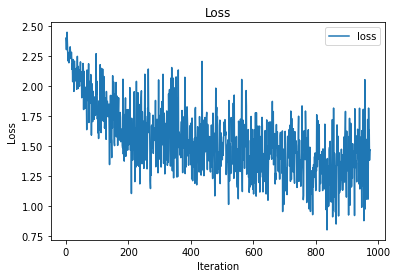

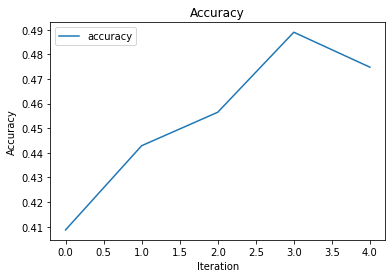

In [6]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [88]:
class FixMatchLoss(nn.Module):
    def __init__(self, tau=0.7):
        super().__init__()
        self._tau = tau

    def forward(self, logp_w: torch.Tensor, logp_s: torch.Tensor):
        if not torch.isnan(logp_w).any() and not torch.isnan(logp_s).any():
            mask = (logp_w.exp() >= self._tau).any(-1)
            if mask.any():
                return F.nll_loss(logp_s[mask], logp_w[mask].argmax(-1))
        return 0.0

class FixMatch(Model):
    def __init__(self, output_dim=10, hidden_dim=128, tau=0.7, lambda_u=10.0):
        super().__init__()
        self.net = Net(output_dim, hidden_dim)

        self.loss = FixMatchLoss(tau)
        self._lambda_u = lambda_u

        self._strong_tf = T.Compose(
            [
                T.RandomResizedCrop(size=32),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                T.Normalize((0.5,) * 3, (0.5,) * 3),
            ]
        )
        self._weak_tf = T.RandomHorizontalFlip(p=0.5)

    def on_after_backward(self):
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.)

    def compute_loss_on_batch(self, x, y):
        mask = y > -1
        xl, yl, xu = x[mask], y[mask], x[~mask]

        xus, xuw = self._strong_tf(xu), self._weak_tf(xu)

        logp_l, logp_w, logp_s = self.net(
            torch.cat([xl, xuw, xus], dim=0)
        ).split((xl.size(0), xuw.size(0), xus.size(0)))

        return F.nll_loss(logp_l, yl) + self._lambda_u * self.loss(logp_w, logp_s)

    def predict_on_batch(self, x):
        return self.net(x)


In [89]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_dl = data.DataLoader(train_data, batch_size=256, drop_last=True, shuffle=True)
    test_dl = data.DataLoader(test_data, batch_size=256)

    fm = FixMatch().to(DEVICE)

    losses, accuracies = fm.fit(train_dl, test_dl, n_epochs=15, lr=1e-3)

    return losses, accuracies

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/3525 [00:00<?, ?it/s]

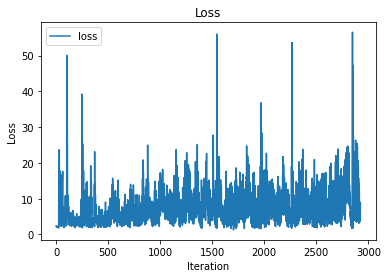

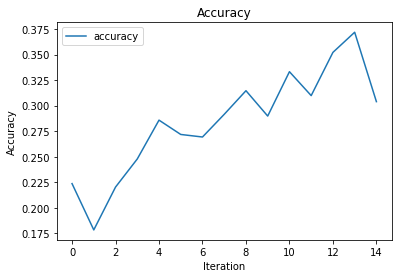

In [90]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """